In [1]:
import pandas as pd
import numpy as np

from __future__ import print_function
import time

from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpld3
from matplotlib.offsetbox import AnchoredText

import plotly.express as px

import seaborn as sns

pd.set_option('display.max_rows', 500)

In [2]:
class QDA:
    def fit(self, X, t):
        self.priors = dict()
        self.means = dict()
        self.covs = dict()
        
        self.classes = np.unique(t)
        
        for c in self.classes:
            X_c = X[t == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.means[c] = np.mean(X_c, axis=0)
            self.covs[c] = np.cov(X_c, rowvar=False)
    
    def predict(self, X):
        preds = list()
        for x in X:
            posts = list()
            for c in self.classes:
                prior = np.log(self.priors[c])
                inv_cov = np.linalg.inv(self.covs[c])
                inv_cov_det = np.linalg.det(inv_cov)
                diff = x-self.means[c]
                likelihood = 0.5*np.log(inv_cov_det) - 0.5*diff.T @ inv_cov @ diff
                post = prior + likelihood
                posts.append(post)
            pred = self.classes[np.argmax(posts)]
            preds.append(pred)
        return np.array(preds)

,Unnamed: 0,recipe_id,nitrate_precs,bi_fe_ratio,separate_hydrolysis,solv1_solv2_ratio,solv_chel_ratio,solv_dehydr_ratio,solv_surfactant_ratio,2_methoxyethanol,...,chem_pca-c24,chem_pca-c25,chem_pca-c26,chem_pca-c27,chem_pca-c28,chem_pca-c29,chem_pca-c30,impurity_code,fe_rich_indicator,bi_rich_indicator
0,0,1.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,0.266144,1.681466,-0.613253,0.640090,0.956314,0.364945,1.274295,0,0,0
1,1,2.0,1,1.050,0,0.0,0.0,0.00000,0.0,1.0,...,2.125564,1.582976,-2.195383,4.887826,-2.184115,1.129147,2.329376,0,0,0
2,2,3.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922,0,0,0
3,3,4.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922,1,1,0
4,4,5.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922,1,1,0
5,5,6.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922,1,1,0
6,6,7.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922,1,1,0
7,7,8.0,1,1.050,0,0.0,0.0,3.00000,0.0,1.0,...,1.598024,0.652660,-1.115405,4.824308,1.894105,2.178952,3.617051,0,0,0
8,8,9.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,0.434308,1.047090,-0.052628,2.188781,3.341397,1.339444,2.211922,0,0,0
9,9,10.0,1,1.100,0,0.0,0.0,0.00000,0.0,1.0,...,2.125564,1.582976,-2.195383,4.887826,-2.184115,1.129147,2.329376,0,0,0


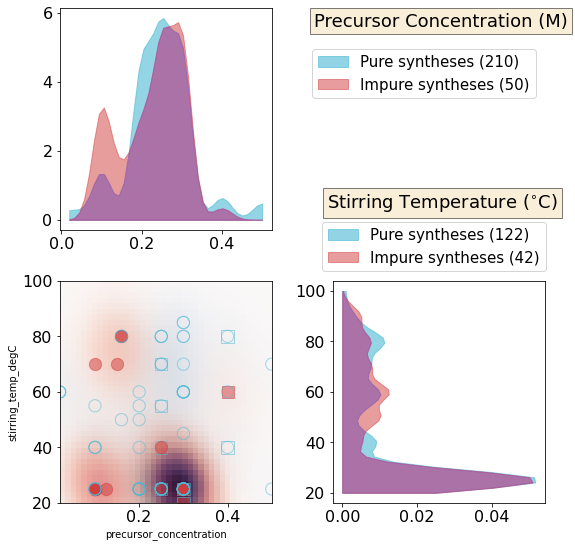

In [6]:
#codified_df = pd.read_csv('./data/bfo_df_codified_20211123.csv')
#refined_df = pd.read_csv('./data/bfo_df_codified_20211123.csv')

codified_df = pd.read_csv('./data/bfo_suggested_df_eda_20221019.csv')
refined_df = pd.read_csv('./data/bfo_suggested_df_eda_20221019.csv')

display(codified_df)

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

#set up pure and impure data series

params_of_interest = [
#     'layer_annealing_degC',
    #'final_annealing_degC',
#     'bi_fe_ratio',
    #'final_annealing_time_hr',
    'precursor_concentration',
    'stirring_temp_degC',
    #'stirring_time_hr'
    #'layer_prebake_degC',
    #'layer_prebake_time_min'
]

labels = {
    'layer_annealing_degC' : 'Layer-by-layer Annealing Temp. ($^{\circ}$C)',
    'final_annealing_degC' : 'Final Annealing Temp. ($^{\circ}$C)',
    'bi_fe_ratio' : 'Bi:Fe Ratio',
    'final_annealing_time_hr' : 'Final Annealing Time (hr)',
    'precursor_concentration' : 'Precursor Concentration (M)',
    'stirring_temp_degC' : 'Stirring Temperature ($^{\circ}$C)',
    'stirring_time_hr' : 'Stirring Time (hr)',
    'layer_prebake_degC' : 'Layer Prebake Temp. ($^{\circ}$C)',
    'layer_prebake_time_min' : 'Layer Prebake Time. (min)'
}

N = len(params_of_interest)

Fig, axs = plt.subplots(N, N, figsize=(8,8))
Fig.tight_layout(pad=3.0)

for i, x_param in enumerate(params_of_interest):
    
    textstr = labels[x_param]
    
    #optionally, remove outliers
    if x_param in [
        'layer_prebake_time_min', 
        'layer_annealing_degC',
        'final_annealing_time_hr', 
        'stirring_temp_degC',
        'final_annealing_degC',
        'layer_prebake_degC']:
        x_max = np.Inf
        x_min = -np.Inf
        if x_param == 'layer_prebake_time_min':
            x_max = 20
        elif x_param == 'layer_annealing_degC':
            x_min = 1
        elif x_param == 'final_annealing_time_hr':
            x_max = 4
        elif x_param == 'stirring_temp_degC':
            x_max = 100
        codified_df[x_param] = codified_df[[x_param]].apply(
            lambda rec: None if rec[x_param]<x_min or rec[x_param]>x_max else rec[x_param],
            axis=1
        )
    
    x = codified_df[~codified_df[x_param].isnull()][['recipe_id', x_param]]
    x_pure_df = codified_df[(codified_df['impurity_code']==0) & (~codified_df[x_param].isnull())][['recipe_id', x_param]]
    x_impure_df = codified_df[(codified_df['impurity_code']==1) & (~codified_df[x_param].isnull())][['recipe_id', x_param]]
    x_pure = x_pure_df[x_param]
    x_impure = x_impure_df[x_param]
    
    x_pure_chel = codified_df[
        (codified_df['impurity_code']==0) &
        (~codified_df[x_param].isnull()) &
        (codified_df[['citric_acid']].sum(axis=1))
    ][['recipe_id', x_param]]
    
    x_impure_chel = codified_df[
        (codified_df['impurity_code']==1) &
        (~codified_df[x_param].isnull()) &
        (codified_df[['citric_acid']].sum(axis=1))
    ][['recipe_id', x_param]]
    
    joined_pure = x_pure_df.merge(
        x_pure_chel, 
        on=['recipe_id'],
        how='left',
        indicator=True
    )[['recipe_id', '{}_x'.format(x_param), '_merge']]
    
    
    joined_impure = x_impure_df.merge(
        x_impure_chel, 
        on=['recipe_id'],
        how='left',
        indicator=True
    )[['recipe_id', '{}_x'.format(x_param), '_merge']]
    
    x_pure_nochel = joined_pure[
        joined_pure['_merge'] == 'left_only'
    ].rename(columns={'{}_x'.format(x_param) : x_param})
    x_impure_nochel = joined_impure[
        joined_impure['_merge'] == 'left_only'
    ].rename(columns={'{}_x'.format(x_param) : x_param})
    
    assert(len(x_pure_nochel)+len(x_pure_chel)==len(x_pure))
    assert(len(x_impure_nochel)+len(x_impure_chel)==len(x_impure))
    
    x_min = min(min(x_pure), min(x_impure))
    x_max = max(max(x_pure), max(x_impure))
    
    xgrid = np.linspace(x_min, x_max, 40)
    
    pure_kde = KernelDensity(bandwidth=0.05*(x_max-x_min), kernel='gaussian')
    pure_kde.fit(np.asarray(x_pure).reshape(-1,1))
    pure_logprob = pure_kde.score_samples(xgrid.reshape(-1,1))
    
    impure_kde = KernelDensity(bandwidth=0.05*(x_max-x_min), kernel='gaussian')
    impure_kde.fit(np.asarray(x_impure).reshape(-1,1))
    impure_logprob = impure_kde.score_samples(xgrid.reshape(-1,1))
    
    ## comment from here to end if you only want binary distribution
    
    if i < len(params_of_interest)-1:
        axs[i,i].fill_between(xgrid, np.exp(pure_logprob), alpha=0.6, label="Pure syntheses ({})".format(len(x_pure)), color='#4bb9d4')
        axs[i,i].fill_between(xgrid, np.exp(impure_logprob), alpha=0.5, label="Impure syntheses ({})".format(len(x_impure)), color='#D23D3D')
        axs[i,i].fill_between(xgrid, np.minimum(np.exp(pure_logprob), np.exp(impure_logprob)), alpha=0.4, color='#9F52C8')
        axs[i,i].legend(loc='upper right', bbox_to_anchor=(2.67, 0.9), fontsize=20)
        axs[i,i].tick_params(axis='x', labelsize=16)
        axs[i,i].tick_params(axis='y', labelsize=16)
        
        props = dict(facecolor='wheat', alpha=0.5)
        axs[i,i].text(1.2, 0.98, textstr, transform=axs[i,i].transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
    else:
        axs[i,i].fill_betweenx(xgrid, np.exp(pure_logprob), alpha=0.6, label="Pure syntheses ({})".format(len(x_pure)), color='#4bb9d4')
        axs[i,i].fill_betweenx(xgrid, np.exp(impure_logprob), alpha=0.5, label="Impure syntheses ({})".format(len(x_impure)), color='#D23D3D')
        axs[i,i].fill_betweenx(xgrid, np.minimum(np.exp(pure_logprob), np.exp(impure_logprob)), alpha=0.4, color='#9F52C8')
        axs[i,i].legend(loc='upper right', bbox_to_anchor=(2.67, 1.24), fontsize=20)
        axs[i,i].tick_params(axis='x', labelsize=16)
        axs[i,i].tick_params(axis='y', labelsize=16)
        
        props = dict(facecolor='wheat', alpha=0.5)
        axs[i,i].text(-0.025, 1.4, textstr, transform=axs[i,i].transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

    ## comment end
    
    for j, y_param in enumerate(params_of_interest):
        if j>i:
            #optionally, remove outliers
            if y_param in ['layer_prebake_time_min', 'final_annealing_time_hr', 'stirring_temp_degC']:
                if y_param == 'layer_prebake_time_min':
                    thresh = 20
                elif y_param == 'final_annealing_time_hr':
                    thresh = 4
                elif y_param == 'stirring_temp_degC':
                    thresh = 100
                codified_df[y_param] = codified_df[[y_param]].apply(
                    lambda rec: None if rec[y_param]>thresh else rec[y_param],
                    axis=1
                )
            y = codified_df[~codified_df[y_param].isnull()][y_param]

            idx = [idx for idx in list(x.index) if idx in list(y.index)]

            y_pure_df = codified_df[(codified_df['impurity_code']==0) & (~codified_df[y_param].isnull())]       
            
            y_impure_df = codified_df[(codified_df['impurity_code']==1) & (~codified_df[y_param].isnull())]
            
            y_pure = y_pure_df[y_param]
            y_impure = y_impure_df[y_param]

            y_pure_chel = codified_df[
                (codified_df['impurity_code']==0) &
                (~codified_df[y_param].isnull()) &
                (codified_df[['citric_acid']].sum(axis=1))
            ][['recipe_id', y_param]]

            y_impure_chel = codified_df[
                (codified_df['impurity_code']==1) &
                (~codified_df[y_param].isnull()) &
                (codified_df[['citric_acid']].sum(axis=1))
            ][['recipe_id', y_param]]

            joined_pure = y_pure_df.merge(
                y_pure_chel, 
                on=['recipe_id'],
                how='left',
                indicator=True
            )[['recipe_id', '{}_x'.format(y_param), '_merge']]


            joined_impure = y_impure_df.merge(
                y_impure_chel, 
                on=['recipe_id'],
                how='left',
                indicator=True
            )[['recipe_id', '{}_x'.format(y_param), '_merge']]

            y_pure_nochel = joined_pure[
                joined_pure['_merge'] == 'left_only'
            ].rename(columns={'{}_x'.format(y_param) : y_param})
            y_impure_nochel = joined_impure[
                joined_impure['_merge'] == 'left_only'
            ].rename(columns={'{}_x'.format(y_param) : y_param})
            
            pure_idx = [idx for idx in list(x_pure.index) if idx in list(y_pure.index)]
            pure_chel_idx = [rec_id for rec_id in x_pure_chel['recipe_id'].to_list() if rec_id in y_pure_chel['recipe_id'].to_list()]
            pure_nochel_idx = [rec_id for rec_id in x_pure_nochel['recipe_id'].to_list() if rec_id in y_pure_nochel['recipe_id'].to_list()]
            
            impure_idx = [idx for idx in x_impure.index if idx in y_impure.index]
            impure_chel_idx = [rec_id for rec_id in x_impure_chel['recipe_id'].to_list() if rec_id in y_impure_chel['recipe_id'].to_list()]
            impure_nochel_idx = [rec_id for rec_id in x_impure_nochel['recipe_id'].to_list() if rec_id in y_impure_nochel['recipe_id'].to_list()]

            pure_data = np.vstack([x_pure.loc[pure_idx],y_pure.loc[pure_idx]])
            impure_data = np.vstack([x_impure.loc[impure_idx],y_impure.loc[impure_idx]])
            
            y_min = min(min(y_pure), min(y_impure))
            y_max = max(max(y_pure), max(y_impure))
            
            ygrid = np.linspace(y_min, y_max, 40)

            Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
            
            pure_kde = gaussian_kde(pure_data)
            Z_pure = pure_kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

            try:
                impure_kde = gaussian_kde(impure_data)
                Z_impure = impure_kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
            except:
                print(x_param)
                print(y_param)
                print(impure_data)

            pure_param_dist = axs[j,i].imshow(Z_pure.reshape(Xgrid.shape), 
                       origin='lower',
                       aspect='auto', 
                       extent=[x_min, x_max, y_min, y_max],
                       cmap="Blues",
                       alpha=1)
            
            impure_param_dist = axs[j,i].imshow(Z_impure.reshape(Xgrid.shape), 
                       origin='lower',
                       aspect='auto', 
                       extent=[x_min, x_max, y_min, y_max],
                       cmap="Reds",
                       alpha=0.5)

            #imp_x = codified_df[codified_df['impurity_code']==1][x_param]
            #imp_y = codified_df[codified_df['impurity_code']==1][y_param]
            #pur_x = codified_df[codified_df['impurity_code']==0][x_param]
            #pur_y = codified_df[codified_df['impurity_code']==0][y_param]

            s = 150
            
            axs[j,i].scatter(x_impure_chel.loc[x_impure_chel['recipe_id'].isin(impure_chel_idx)][x_param], y_impure_chel.loc[y_impure_chel['recipe_id'].isin(impure_chel_idx)][y_param], c='#D23D3D', alpha=0.5, s=s, marker='s')
            axs[j,i].scatter(x_pure_chel.loc[x_pure_chel['recipe_id'].isin(pure_chel_idx)][x_param], y_pure_chel.loc[y_pure_chel['recipe_id'].isin(pure_chel_idx)][y_param], facecolors='none', edgecolors='#4bb9d4', alpha=0.5, s=s, marker='s')

            axs[j,i].scatter(x_impure_nochel.loc[x_impure_nochel['recipe_id'].isin(impure_nochel_idx)][x_param], y_impure_nochel.loc[y_impure_nochel['recipe_id'].isin(impure_nochel_idx)][y_param], c='#D23D3D', alpha=0.5, s=s)
            axs[j,i].scatter(x_pure_nochel.loc[x_pure_nochel['recipe_id'].isin(pure_nochel_idx)][x_param], y_pure_nochel.loc[y_pure_nochel['recipe_id'].isin(pure_nochel_idx)][y_param], facecolors='none', edgecolors='#4bb9d4', alpha=0.5, s=s)

            axs[j,i].set_xlabel(x_param)
            axs[j,i].set_ylabel(y_param)
            
            axs[j,i].tick_params(axis='x', labelsize=16)
            axs[j,i].tick_params(axis='y', labelsize=16)
            
            ## comment here if you also want unary distributions
            
#             axs[j,i].set_xlabel(labels[x_param], fontsize=20)
#             axs[j,i].set_ylabel(labels[y_param], fontsize=20)
            
            ## end comment
            
            #QDA
#             X = pd.concat([refined_df[x_param], refined_df[y_param]], axis=1).to_numpy()
#             t = refined_df['impurity_code'].to_numpy()

#             qda = QDA()
#             qda.fit(X, t)
#             preds = qda.predict(X)

#             correct = 0
#             for true, pred in zip(t, preds):
#                 if true == pred:
#                     correct +=1 
                    
#             qda_accuracy = correct/len(t)
            
#             anchored_text = AnchoredText(
#                 "QDA accuracy: {0:.2f}".format(qda_accuracy), 
#                 loc='lower left', prop=dict(size=16), frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=axs[j,i].transAxes
#             )
#             axs[j,i].add_artist(anchored_text)

        elif j!=i: # or j==i: # include extra boolean if you only want binary
            Fig.delaxes(axs[j,i])

axs[0,0].legend(loc='upper right', bbox_to_anchor=(2.28, 0.85), fontsize=15)
axs[1,1].legend(loc='upper right', bbox_to_anchor=(1.04, 1.3), fontsize=15)
plt.show()
#Fig.savefig('/Users/kevcruse96/Desktop/D2S2/TriennialReview/Presentation/annealtime_stirtemp_sugg.png', bbox_inches="tight")

# Full factorial 

In [4]:
print(codified_df['stirring_time_hr'].median())

2.0
